# Tutorial: Entendimiento de los datos con PySpark

Continuando con el proyecto de consultoria de Wide World Importers, el primer paso para iniciar la comprensión de los datos es explorar y entender las fuentes de datos disponibles. Note que esto también nos ayuda a comprender mejor la organización.

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
%matplotlib notebook 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#plt.rcParams['figure.max_open_warning'] = 30  # or any other number 
#matplotlib.use('TkAgg')  # Usando el backend TkAgg

Configuración del controlador e inicio de sesion Spark

In [3]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [4]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [5]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/RaSaTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_67_202315'
db_psswd = 'aabb1122'

PATH='./'

### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [6]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

### Completitud y validez

In [37]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados 

# Checking "" values 
def contar_vacios_str(df, printing = True):
    resultados = []
    for c in df.columns:
        vacios = df.filter((df[c] == "")).count()
        if vacios != 0: 
            if printing: 
                print('Number of "" values for column ' + c + ': ' + str(vacios))
            resultados.append(vacios)
    return resultados 


def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

# 5. Tarea
Espacio para desarrollar la tarea propuesta 

### Perfilamiento de datos

#### Entendimiento general de datos

In [40]:
# Getting Df from WWImportersTransactional.movimientosCopia 
sql_FuenteAreasDeServicio_Copia_E = 'RaSaTransaccional.FuenteAreasDeServicio_Copia_E'
sql_FuenteCondicionesDePago_Copia_E = 'RaSaTransaccional.FuenteCondicionesDePago_Copia_E'
sql_FuenteTiposBeneficio_Copia_E = 'RaSaTransaccional.FuenteTiposBeneficio_Copia_E'
sql_movimientosCopia = 'RaSaTransaccional.FuentePlanesBeneficio_Copia_E'

movimientosCopia = obtener_dataframe_de_bd(db_connection_string, sql_movimientosCopia, db_user, db_psswd) 
FuenteAreasDeServicio_Copia_E = obtener_dataframe_de_bd(db_connection_string, sql_FuenteAreasDeServicio_Copia_E, db_user, db_psswd) 
FuenteCondicionesDePago_Copia_E = obtener_dataframe_de_bd(db_connection_string, sql_FuenteCondicionesDePago_Copia_E, db_user, db_psswd)  
FuenteTiposBeneficio_Copia_E = obtener_dataframe_de_bd(db_connection_string, sql_FuenteTiposBeneficio_Copia_E, db_user, db_psswd)   
# Exploring the table 
movimientosCopia.show(5) 

+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|              640|          10382017|                       34|                         27|                3|16842FL0070128-03|2017-12-31|        16842|          0|           50|            35|
|              225|          31512017|                      238|                         45|                2|29418TX0140002-04|2017-12-31|        29418|          0|            0|          null|
|              190|      

In [9]:
# Getting each column's type 
print("Columns' type") 
print(movimientosCopia.schema) 
# Printing df's dimensions 
print("\n Df's dimensions") 
print((movimientosCopia.count(), len(movimientosCopia.columns))) 

Columns' type
StructType(List(StructField(IdTipoBeneficio_T,LongType,true),StructField(IdAreaDeServicio_T,LongType,true),StructField(IdCondicionDePagoCopago_T,IntegerType,true),StructField(IdCondicionDePagoCoseguro_T,IntegerType,true),StructField(IdNivelServicio_T,IntegerType,true),StructField(IdPlan_T,StringType,true),StructField(Fecha,StringType,true),StructField(IdProveedor_T,IntegerType,true),StructField(valorCopago,IntegerType,true),StructField(valorCoseguro,IntegerType,true),StructField(cantidadLimite,IntegerType,true)))

 Df's dimensions
(36036, 11)


#### Revisión de reglas de negocio

In [10]:
"""
    1) The maximum Copayment and Coinsurance value for the year 2018 is respectively 3300 and 100 
"""
print("\n1) The maximum amount of products moved is 50 million per transaction ".center(20, '*')) 

"""
    First, we'll need to check the column "Fecha"
"""

# Filtering those columns that satisfied the format 
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
fulfillsFormat_FT = movimientosCopia.filter(movimientosCopia["Fecha"].rlike(regex)) 
print("\nTotal number of orders: " + str(movimientosCopia.count()) + ", number of orders with correct format: " + str(fulfillsFormat_FT.count()))

# Checking those rows that doesn't fit the format 
noFulfillsFormat_FT = movimientosCopia.filter(~movimientosCopia["Fecha"].rlike(regex)) 
noFulfillsFormat_FT.count(), noFulfillsFormat_FT.select(col("Fecha")).show() 
print(f"Number of rows that doesn't fit the correct format: {noFulfillsFormat_FT.count()}") 

# Checking if there are another different kind of values in this column 
print(f"Checking if there are some different values in the column: ")
movimientosCopia.where(length(col("Fecha")) <= 9).show()

# Convert the "Fecha" column to a date type
movimientosCopia = movimientosCopia.withColumn("Fecha", movimientosCopia["Fecha"].cast("date"))
# Filter the DataFrame to include only records for the year 2018
df_2018 = movimientosCopia.filter(functions.year(movimientosCopia["Fecha"]) == 2018)

# Find the maximum copayment and coinsurance values for the year 2018
max_copayment = df_2018.agg({"valorCopago": "max"}).collect()[0][0]
max_coinsurance = df_2018.agg({"valorCoseguro": "max"}).collect()[0][0]

# Show the maximum values
print(f"The maximum Copayment value for the year 2018 is: {max_copayment}")
print(f"The maximum Coinsurance value for the year 2018 is: {max_coinsurance}") 

# Checking if there are any value above 3000 close to 3300 
# Filter the DataFrame for the year 2018 and valorCopago >= 3000
filtered_df = movimientosCopia.filter((functions.year(movimientosCopia["Fecha"]) == 2018) & (movimientosCopia["valorCopago"] >= 3000))

# Perform the aggregation and select the desired columns
result_df = filtered_df.groupBy("valorCopago").count()

# Show the result 
print("Number of valorCopago and how many times these are repeated when exceeding 2999")
result_df.show()

"""
    Given that the maximum value for 'valorCopago' in a transaction made 
    in 2018 is 3500, it can be assumed that this rule has been violated, 
    and there are no values near 3300 either.
"""

"""
    2) In addition, it shares information on 301 plans for 2017 and 422 for 2018.
"""
# Filter the DataFrame for the years 2017 and 2018
filtered_df = movimientosCopia.filter(functions.year(movimientosCopia["Fecha"]).isin([2017, 2018]))

# Perform the aggregation and select the desired columns
result_df = filtered_df.groupBy(functions.year(movimientosCopia["Fecha"]).alias("Year")).agg(functions.countDistinct("IdPlan_T").alias("DistinctPlansCount"))

# Show the result 
print("Amount of plans in years 2017 and 2018")
result_df.show()

"""
    This rule isn't true since 2018 has 286 and 2017 has 203. 
"""


1) The maximum amount of products moved is 50 million per transaction 

Total number of orders: 36036, number of orders with correct format: 33980
+-----------+
|      Fecha|
+-----------+
|Dec 31,2017|
|Dec 31,2017|
|Dec 31,2018|
|Dec 31,2017|
|Dec 31,2017|
|Dec 31,2018|
|Dec 31,2017|
|Dec 31,2018|
|Dec 31,2017|
|Dec 31,2018|
|Dec 31,2017|
|Dec 31,2018|
|Dec 31,2018|
|Dec 31,2018|
|Dec 31,2017|
|Dec 31,2018|
|Dec 31,2018|
|Dec 31,2018|
|Dec 31,2018|
|Dec 31,2018|
+-----------+
only showing top 20 rows

Number of rows that doesn't fit the correct format: 2056
Checking if there are some different values in the column: 
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|IdPlan_T|Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+----------

"\n    This rule isn't true since 2018 has 286 and 2017 has 203. \n"

### Análisis descriptivo

In [11]:
# Assuming you have a DataFrame named "movimientosCopia"
summary_df = movimientosCopia.summary()

# Convert the summary DataFrame to a Pandas DataFrame
summary_pandas_df = summary_df.toPandas()

# Display the Pandas DataFrame as a table in Jupyter Notebook
summary_pandas_df  

,summary,IdTipoBeneficio_T,IdAreaDeServicio_T,IdCondicionDePagoCopago_T,IdCondicionDePagoCoseguro_T,IdNivelServicio_T,IdPlan_T,IdProveedor_T,valorCopago,valorCoseguro,cantidadLimite
0,count,33950,33995,36036,36036,36036,36036,36036,36036,36036,5465
1,mean,584.5048600883653,6.5241141408707164E7,140.41575091575092,38.913836163836166,1.9995282495282496,None,50047.9141969142,9.778416028416029,24.29279054279054,129.3313815187557
2,stddev,389.10718321864107,4.1855071792570606E7,100.6484295699994,8.772172187785234,0.8173400355652516,None,25560.661568535215,100.41137967701272,36.959755494458506,951.2795862330698
3,min,5,12018,17,9,1,,10207,0,0,1
4,25%,275,38002018,34,27,1,None,33602,0,0,1
5,50%,565,52142017,238,45,2,None,39424,0,0,25
6,75%,820,88552018,238,45,3,None,67243,0,50,40
7,max,2110,235734036,238,45,3,99969OH0080069-00,99969,3500,100,30000


In [12]:

# Filter the DataFrame where valorCopago = 0 and select the minimum valorCoseguro
df1 = movimientosCopia.filter(movimientosCopia["valorCopago"] == 0).agg({"valorCoseguro": "min"})

# Filter the DataFrame where valorCoseguro = 0 and select the minimum valorCopago
df2 = movimientosCopia.filter(movimientosCopia["valorCoseguro"] == 0).agg({"valorCopago": "min"})

# Union the two DataFrames
result_df = df1.unionAll(df2)

# Show the result 
print("min values in valorCoseguro and valorCopago when both are 0")
result_df.show() 

"""
    *** It seems that 'cantidadLimite' has a high number of null 
    values. Is this condition due to some plans that do not have 
    any limit on their amount? 
    
    *** Why are there 0 values in 'valorCopago' and 'valorCoseguro' 
    when some of them are 0, i.e., the minimum 'valorCoseguro' 
    value when 'valorCoseguro' = 0 is 0, and vice versa?
"""

min values in valorCoseguro and valorCopago when both are 0
+------------------+
|min(valorCoseguro)|
+------------------+
|                 0|
|                 0|
+------------------+



"\n    *** It seems that 'cantidadLimite' has a high number of null \n    values. Is this condition due to some plans that do not have \n    any limit on their amount? \n    \n    *** Why are there 0 values in 'valorCopago' and 'valorCoseguro' \n    when some of them are 0, i.e., the minimum 'valorCoseguro' \n    value when 'valorCoseguro' = 0 is 0, and vice versa?\n"

<IPython.core.display.Javascript object>


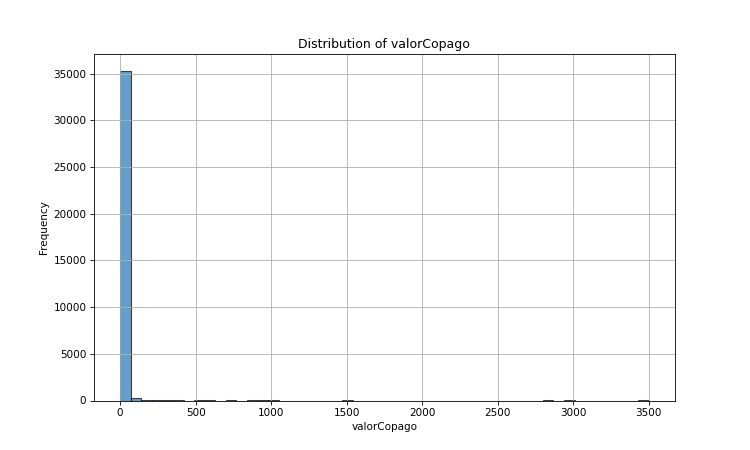

<IPython.core.display.Javascript object>


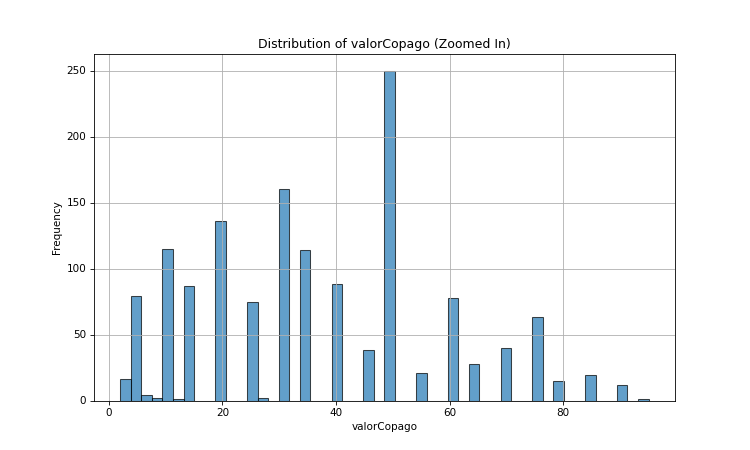

<IPython.core.display.Javascript object>


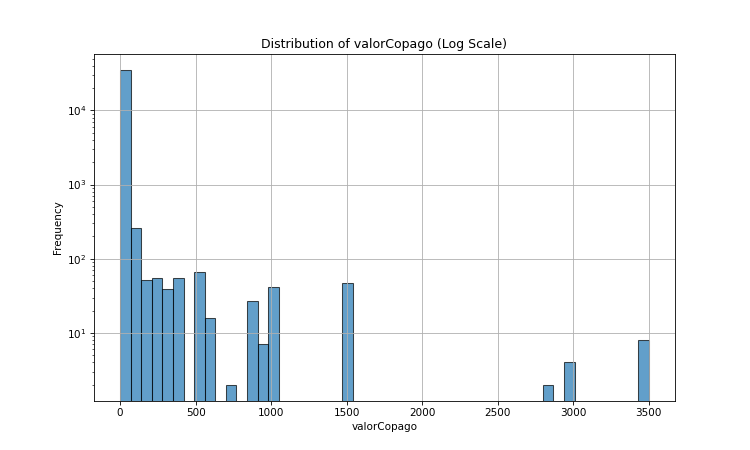

<IPython.core.display.Javascript object>


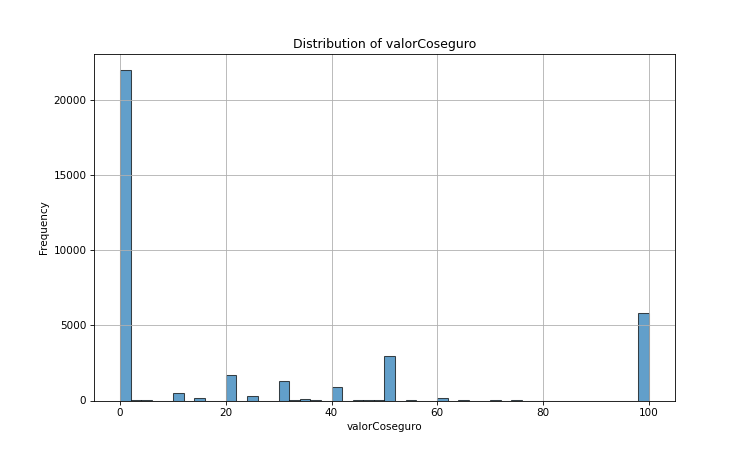

<IPython.core.display.Javascript object>


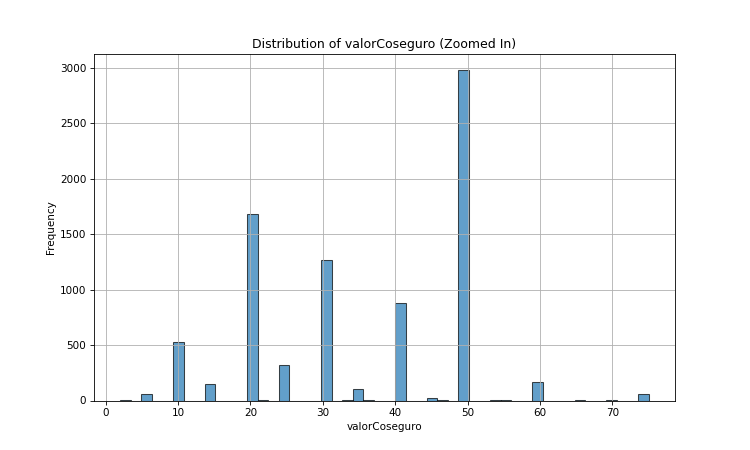

<IPython.core.display.Javascript object>


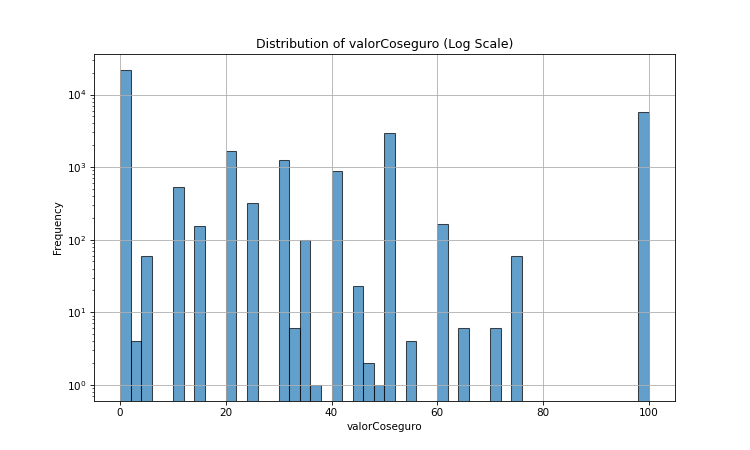

"\n    It can be seen how the distribution of 'valorCopago' is concentrated \n    in small values but contains very large outliers on the entire \n    x-axis, with the case of 'valorCoseguro' being very similar, but less \n    concentrated in small values\n"

In [21]:
import matplotlib.pyplot as plt

def plot_histogram(df, column_name, zoomed_in=False, min_value=None, max_value=None, log_scale=False):
    """
    Plot a histogram for a specified column in a DataFrame.

    Parameters:
    - df: PySpark DataFrame
    - column_name: Name of the column to plot
    - zoomed_in: Whether to zoom in by setting a range for the x-axis
    - min_value: Minimum value for the x-axis (used when zoomed_in is True)
    - max_value: Maximum value for the x-axis (used when zoomed_in is True)
    - log_scale: Whether to use a log scale for the y-axis
    """
    column_list = df.select(column_name).rdd.flatMap(lambda x: x).collect()
    
    # Filter out None (null) values
    column_list = [x for x in column_list if x is not None]
    
    plt.figure(figsize=(10, 6))
    
    if zoomed_in:
        plt.hist([x for x in column_list if min_value < x < max_value], bins=50, edgecolor='black', alpha=0.7)
    else:
        plt.hist(column_list, bins=50, edgecolor='black', alpha=0.7)
    
    plt.title(f'Distribution of {column_name}' + (' (Zoomed In)' if zoomed_in else '') + (' (Log Scale)' if log_scale else ''))
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    
    if log_scale:
        plt.yscale('log')
    
    plt.show()


# Example usage:
# Plotting the distribution of 'Cantidad' from the 'movimientosCopia' DataFrame
# To zoom in, set zoomed_in=True and specify min_value and max_value
plot_histogram(movimientosCopia, 'valorCopago')
plot_histogram(movimientosCopia, 'valorCopago', zoomed_in=True, min_value=1, max_value=100)
plot_histogram(movimientosCopia, 'valorCopago', log_scale=True)

plot_histogram(movimientosCopia, 'valorCoseguro')
plot_histogram(movimientosCopia, 'valorCoseguro', zoomed_in=True, min_value=1, max_value=100)
plot_histogram(movimientosCopia, 'valorCoseguro', log_scale=True)

"""
    It can be seen how the distribution of 'valorCopago' is concentrated 
    in small values but contains very large outliers on the entire 
    x-axis, with the case of 'valorCoseguro' being very similar, but less 
    concentrated in small values
"""

<IPython.core.display.Javascript object>


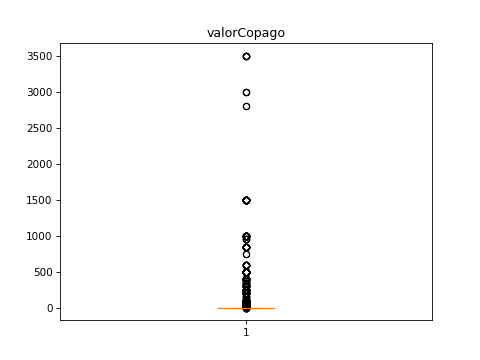

{'whiskers': [<matplotlib.lines.Line2D at 0x1bc790e2c48>,
 'caps': [<matplotlib.lines.Line2D at 0x1bc790e2248>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bc79136588>],
 'medians': [<matplotlib.lines.Line2D at 0x1bc7991d248>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bc7991d648>],
 'means': []}

In [18]:
fig1, ax1 = plt.subplots()
ax1.set_title('valorCopago')
ax1.boxplot(np.array(movimientosCopia.select('valorCopago').collect()))

<IPython.core.display.Javascript object>


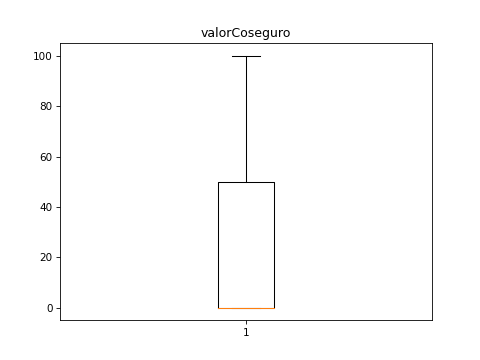

{'whiskers': [<matplotlib.lines.Line2D at 0x1bc797e4188>,
 'caps': [<matplotlib.lines.Line2D at 0x1bc798dd488>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bc77167bc8>],
 'medians': [<matplotlib.lines.Line2D at 0x1bc79902808>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bc798d63c8>],
 'means': []}

In [19]:
fig1, ax1 = plt.subplots()
ax1.set_title('valorCoseguro')
ax1.boxplot(np.array(movimientosCopia.select('valorCoseguro').collect()))

<IPython.core.display.Javascript object>


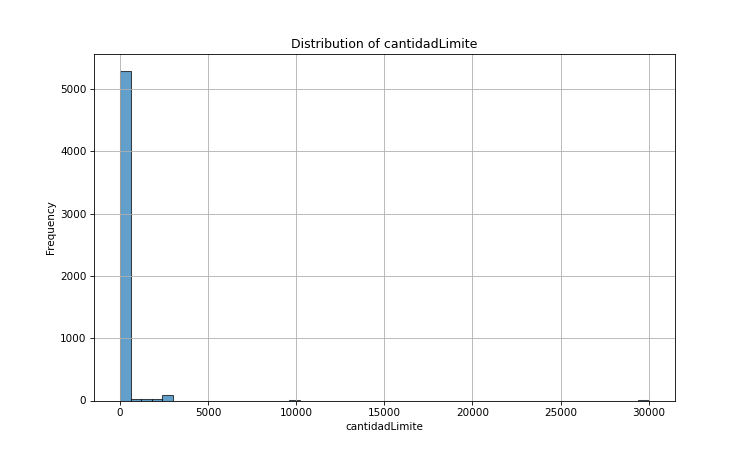

<IPython.core.display.Javascript object>


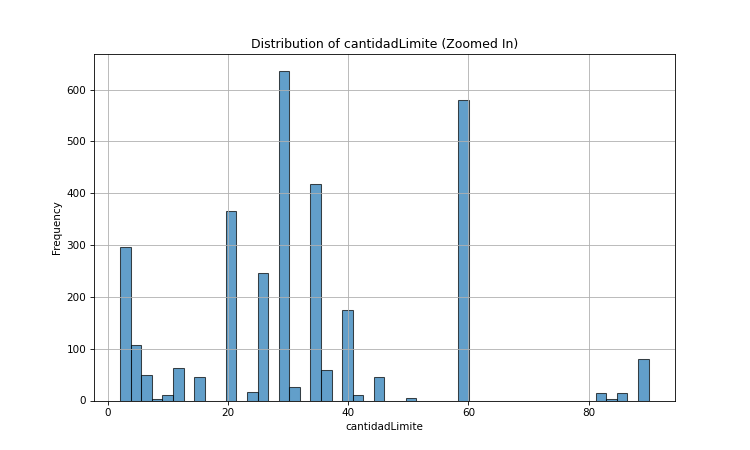

<IPython.core.display.Javascript object>


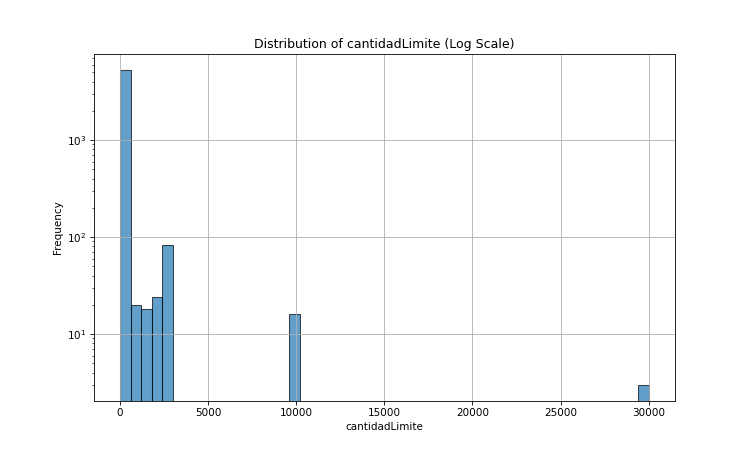

In [22]:
plot_histogram(movimientosCopia, 'cantidadLimite')
plot_histogram(movimientosCopia, 'cantidadLimite', zoomed_in=True, min_value=1, max_value=100)
plot_histogram(movimientosCopia, 'cantidadLimite', log_scale=True) 

"""
    In the case of cantidadLimite, it's observed that the values 
    are mostly concentrated in values under 2500 but there are 
    a high amount of outliers. 
"""

<IPython.core.display.Javascript object>


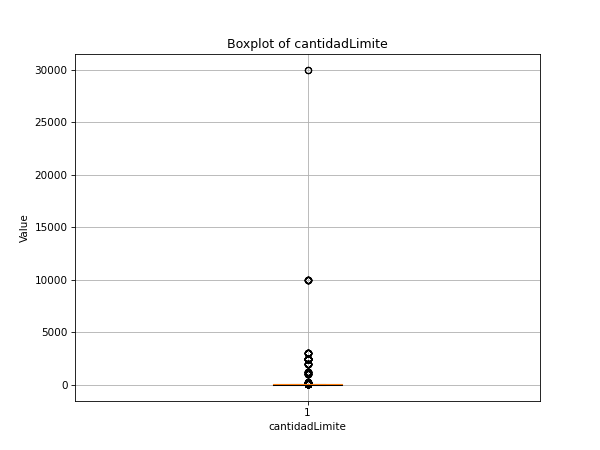

In [26]:
cantidadLimite_values = movimientosCopia.select('cantidadLimite').rdd.flatMap(lambda x: x).collect()

# Filter out None (null) values
cantidadLimite_values = [x for x in cantidadLimite_values if x is not None]

# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(cantidadLimite_values)
plt.title('Boxplot of cantidadLimite')
plt.xlabel('cantidadLimite')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Number of total rows: 36036
Number of '' rows: 2053
% of duplicated rows: 0.7643190143190143


<IPython.core.display.Javascript object>


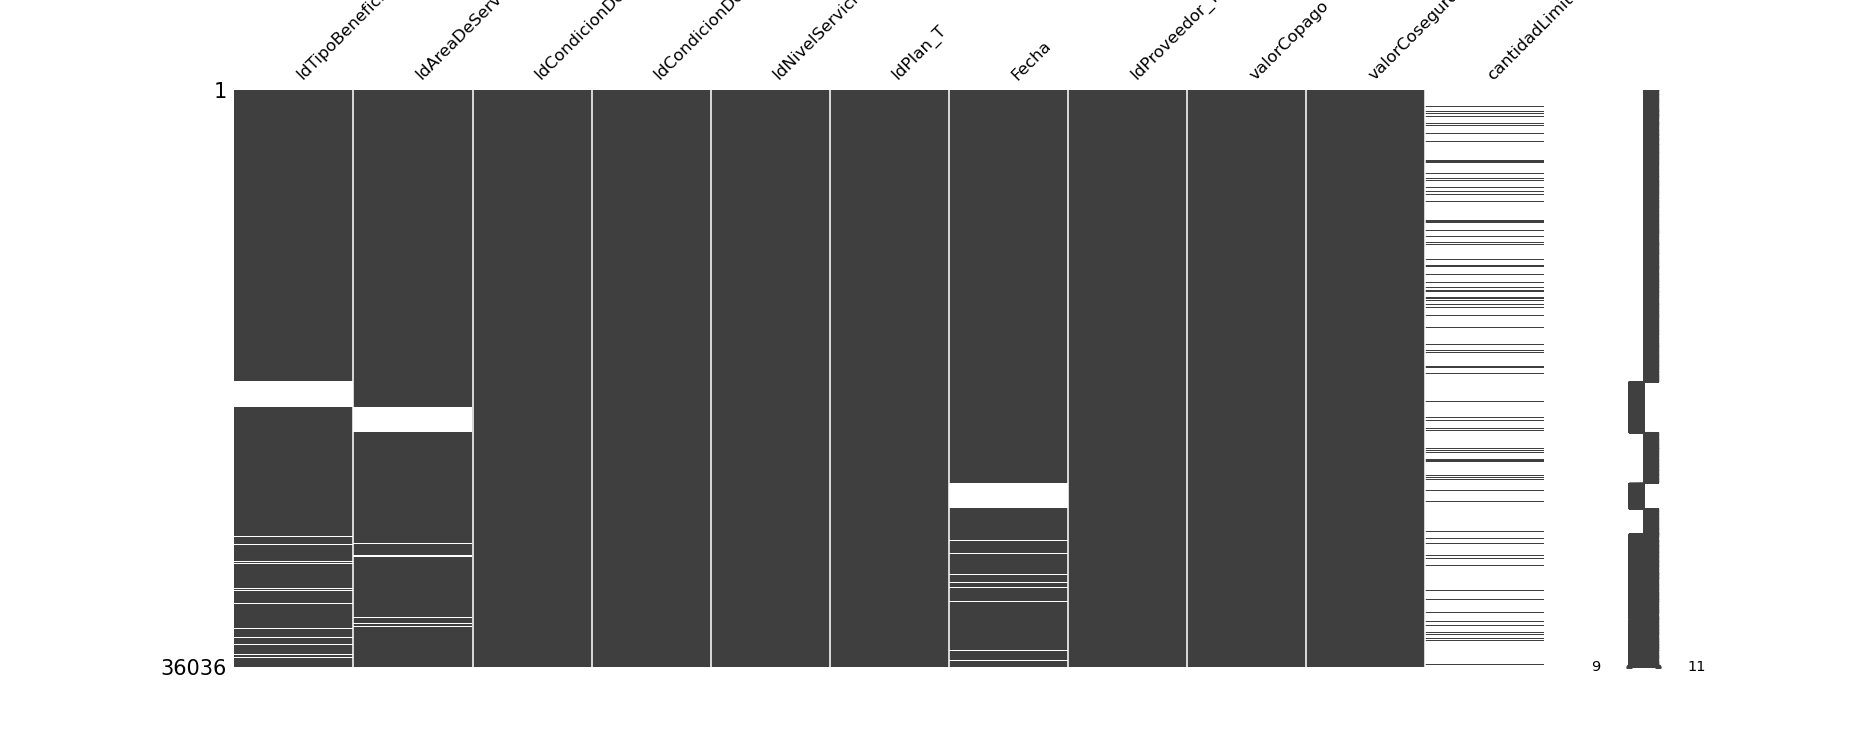

<AxesSubplot:>

In [27]:
import missingno as msno 
print(f"Number of total rows: {movimientosCopia.count()}") 
print(f"Number of '' rows: {contar_vacios_str(movimientosCopia, False)[0]}") 
print(f"% of duplicated rows: {movimientosCopia.distinct().count()/movimientosCopia.count()}") 
# Patterns of data completion 
msno.matrix(movimientosCopia.toPandas()) 

In [28]:
missing_percentage = movimientosCopia.toPandas().isnull().mean() * 100

for column, percentage in missing_percentage.items():
    print(f"{column}: {percentage:.2f}% missing") 
    
"""
    *** Why are columns with 'IdTipoBeneficio_T' null? Maybe these 
    plans didn't have any benefits? The same goes for 
    'IdAreaDeServicio_T.' 
"""

IdTipoBeneficio_T: 5.79% missing
IdAreaDeServicio_T: 5.66% missing
IdCondicionDePagoCopago_T: 0.00% missing
IdCondicionDePagoCoseguro_T: 0.00% missing
IdNivelServicio_T: 0.00% missing
IdPlan_T: 0.00% missing
Fecha: 5.71% missing
IdProveedor_T: 0.00% missing
valorCopago: 0.00% missing
valorCoseguro: 0.00% missing
cantidadLimite: 84.83% missing


In [29]:
df_summary = movimientosCopia.describe()

# Counting unique values 
unique_counts = {
    'IdTipoBeneficio_T': movimientosCopia.select('IdTipoBeneficio_T').distinct().count(),
    'IdAreaDeServicio_T': movimientosCopia.select('IdAreaDeServicio_T').distinct().count(),
    'IdCondicionDePagoCopago_T': movimientosCopia.select('IdCondicionDePagoCopago_T').distinct().count(),
    'IdCondicionDePagoCoseguro_T': movimientosCopia.select('IdCondicionDePagoCoseguro_T').distinct().count(),
    'IdNivelServicio_T': movimientosCopia.select('IdNivelServicio_T').distinct().count(),
    'IdPlan_T': movimientosCopia.select('IdPlan_T').distinct().count(),
    'Fecha': movimientosCopia.select('Fecha').distinct().count(),
    'IdProveedor_T': movimientosCopia.select('IdProveedor_T').distinct().count(),
    'valorCopago': movimientosCopia.select('valorCopago').distinct().count(),
    'valorCoseguro': movimientosCopia.select('valorCoseguro').distinct().count(),
    'cantidadLimite': movimientosCopia.select('cantidadLimite').distinct().count(),
}

# Date range 
date_range = movimientosCopia.agg(
    functions.min('Fecha').alias('Fecha Minima'),
    functions.max('Fecha').alias('Fecha Maxima')
)

print("Unique values on each column: ") 
print(unique_counts) 
print("Date range: ") 
date_range.show() 

Unique values on each column: 
{'IdTipoBeneficio_T': 286, 'IdAreaDeServicio_T': 6497, 'IdCondicionDePagoCopago_T': 14, 'IdCondicionDePagoCoseguro_T': 5, 'IdNivelServicio_T': 3, 'IdPlan_T': 393, 'Fecha': 4, 'IdProveedor_T': 125, 'valorCopago': 49, 'valorCoseguro': 25, 'cantidadLimite': 42}
Date range: 
+------------+------------+
|Fecha Minima|Fecha Maxima|
+------------+------------+
|  1920-12-31|  2018-12-31|
+------------+------------+



<IPython.core.display.Javascript object>


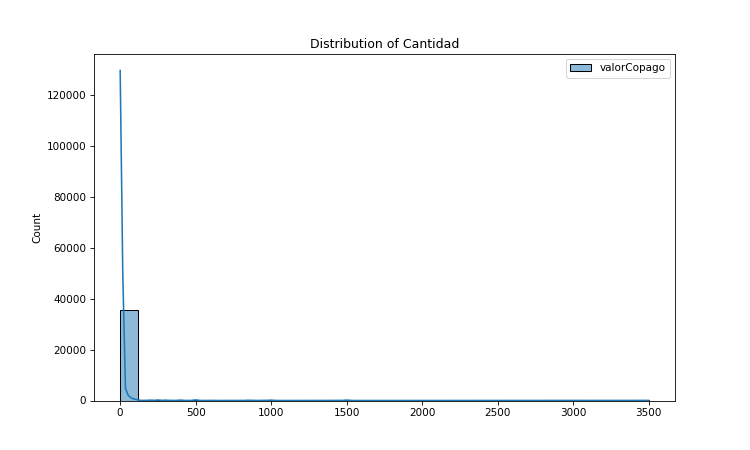

<IPython.core.display.Javascript object>


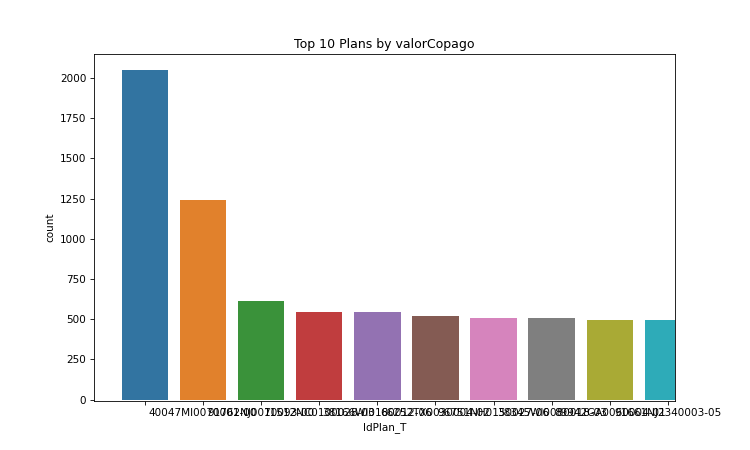

In [31]:
import pandas as pd 
import seaborn as sns 
# 1. Distribution of `Cantidad`
df_cantidad = movimientosCopia.select("valorCopago").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(df_cantidad, bins=30, kde=True)
plt.title('Distribution of valorCopago')
plt.show()

# 3. Top Products by Transactions
df_product = movimientosCopia.groupBy('IdPlan_T').count().sort('count', ascending=False).limit(10).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=df_product, x='IdPlan_T', y='count')
plt.title('Top 10 Plans')
plt.show() 

"""
    It appears that the plan '40047MI0070001-00' is the most frequently 
    used followed by 91762NJ0070093-00.  
"""

### Análisis de calidad de datos

##### Unicidad 

In [35]:
print(f"Number of distinct rows: {movimientosCopia.distinct().count()}")
print(f"Number of total rows: {movimientosCopia.count()}") 

""" 
    One could think that every value in this table is unique and 
    different, but according the upper analysis, there are some 
    duplicated values. So uniqueness is not fulfilled. Also, why 
    are some plans repeated but with different attributes? like 
    the plan 38345WI0080018-03. 
"""

"""
    In terms of validity, the dates do not entirely have a single format, 
    just as there are empty fields that could be important, such as 
    IdTipoBeneficio_T and IdAreaDeServicio_T, which could be important for some 
    cross-checking of information or subsequent analysis. 
"""

Number of distinct rows: 27543
Number of total rows: 36036


'\n    In terms of validity, the dates do not entirely have a single format, \n    just as there are empty fields that could be important, such as \n    IdTipoBeneficio_T and IdAreaDeServicio_T, which could be important for some \n    cross-checking of information or subsequent analysis. \n'

##### Completitud y validez

In [38]:
print("NULL Values: ")
empty_columns_movimientosCopia = contar_vacios(movimientosCopia) 
print("'' Values: ")
empty_columns_movimientosCopia_str = contar_vacios_str(movimientosCopia)

print("\n Cardinality")
movimientosCopia_c = cardinalidad(movimientosCopia) 
print(f"{movimientosCopia_c}") 

"""
    Checking the columns with "" values, just IdPlan_T has columns with 
    missing data, probably the most important column here. It needs to 
    be asked to the client if this is Ok, because it seems important 
    to have the IdPlan_T value! 
    
    Regarding cardinality, none of the columns here have a high 
    cardinality, which means that the id columns have several 
    duplicates. 
    
    IdTipoBeneficio_T has 2086 null values. 
    IdAreaDeServicio_T has 2041 null values. 
    Fecha has 2056 null values. 
    cantidadLimite has 30571 null values. 
"""

NULL Values: 
número de vacíos para columna IdTipoBeneficio_T: 2086
número de vacíos para columna IdAreaDeServicio_T: 2041
número de vacíos para columna Fecha: 2056
número de vacíos para columna cantidadLimite: 30571
'' Values: 
Number of "" values for column IdPlan_T: 2053

 Cardinality
{}


'\n    Checking the columns with "" values, just IdPlan_T has columns with \n    missing data, probably the most important column here. It needs to \n    be asked to the client if this is Ok, because it seems important \n    to have the IdPlan_T value! \n    \n    Regarding cardinality, none of the columns here have a high \n    cardinality, which means that the id columns have several \n    duplicates. \n    \n    IdTipoBeneficio_T has 2086 null values. \n    IdAreaDeServicio_T has 2041 null values. \n    Fecha has 2056 null values. \n    cantidadLimite has 30571 null values. \n'

##### Validez

In [ ]:
"""
    This rule was checked when validating the businnes rule 
    "The maximum Copayment and Coinsurance value for the year 
    2018 is respectively 3300 and 100", where we checked 
    some dates with the months in words instead of numbers 
    i.e. "Dec 31,2017" or "Dec 31,2018". 
    
    There are null values in cantidadLimite, but we don't 
    know yet if this is OK. 
"""

##### Consistencia¶

In [54]:
distinct_dates = movimientosCopia.filter(col("fecha") <= '1990-01-01').select("fecha").distinct()

# Show the distinct dates
distinct_dates.show() 


#consistencia: revisar genially: definicion de consistencia

filtered_df_cop = FuenteCondicionesDePago_Copia_E.filter(FuenteCondicionesDePago_Copia_E.Tipo == 'Copago')
filtered_df_cos = FuenteCondicionesDePago_Copia_E.filter(FuenteCondicionesDePago_Copia_E.Tipo == 'Coseguro')

# Select distinct 'IdCondicionesDePago_T' and collect the results as a list
ids_condiciones_Copago = list(set(filtered_df_cop.select('IdCondicionesDePago_T').rdd.flatMap(lambda x: x).collect()))
ids_condiciones_Coseguro = list(set(filtered_df_cos.select('IdCondicionesDePago_T').rdd.flatMap(lambda x: x).collect()))

ids_areas_servicio = set([x.IdAreaDeServicio_T for x in FuenteAreasDeServicio_Copia_E.select('IdAreaDeServicio_T').collect()])
#ids_condiciones_pago = set([x.IdCondicionesDePago_T for x in FuenteCondicionesDePago_Copia_E.select('IdCondicionesDePago_T').collect()])
ids_beneficios = set([x.IdTipoBeneficio_T for x in FuenteTiposBeneficio_Copia_E.select('IdTipoBeneficio_T').collect()]) 

hechos_ids_areas_servicio = set([x.IdAreaDeServicio_T for x in movimientosCopia.select('IdAreaDeServicio_T').collect()])
hechos_ids_condiciones_Copago = set([x.IdCondicionDePagoCopago_T for x in movimientosCopia.select('IdCondicionDePagoCopago_T').collect()])
hechos_ids_condiciones_Coseguro = set([x.IdCondicionDePagoCoseguro_T for x in movimientosCopia.select('IdCondicionDePagoCoseguro_T').collect()])
hechos_ids_beneficios = set([x.IdTipoBeneficio_T for x in movimientosCopia.select('IdTipoBeneficio_T').collect()])

print("ids_areas_servicio")
print(len(ids_areas_servicio), len(hechos_ids_areas_servicio)-2041)
print("ids_condiciones_Copago")
print(len(ids_condiciones_Copago), len(hechos_ids_condiciones_Copago)) 
print("ids_condiciones_Coseguro")
print(len(ids_condiciones_Coseguro), len(hechos_ids_condiciones_Coseguro)) 
print("ids_beneficios")
print(len(ids_beneficios), len(hechos_ids_beneficios)) 


"""    
    *** Why are plans with dates from 1920-12-31?  
    
    *** Why are cantidadLimite null values? 
    
    *** Why are there ids_beneficios that aren't in the table IdTipoBeneficio_T? 
    i.e. 2090, 1450, 1890. 
"""

+----------+
|     fecha|
+----------+
|1920-12-31|
+----------+

ids_areas_servicio
5410 4456
ids_condiciones_Copago
14 14
ids_condiciones_Coseguro
5 5
ids_beneficios
178 286


'    \n    *** Why are plans with dates from 1920-12-31?  \n    \n    *** Why are cantidadLimite null values? \n    \n    *** \n'

### Conclusiones

In [ ]:

**Conclusiones generales:**

1. En la tabla WWImportersTransactional.movimientosCopia tenemos información relacionada a las transacciones de importación/distribución junto a algunos detalles como el proveedor, el cliente, el producto, el tipo de transacción, fecha, cantidad y entre otros. 

**Conclusiones de reglas de negocio:**

1. Casi que ninguna de las reglas de negocio se cumple. En el desarrollo de estas se explicó a detalle el porqué. Aunque podría decirse que la primera se puede interpretar como verdadera, ya que no rompe necesariamente el límite dado. Por otro lado, la segunda es mayormente falsa pero tiene un poco de verdadera, ya que sí tiene transacciones en 2013, solo que corresponden al último día de ese año.

**Conclusiones de calidad:** 

1. Se puede observar que el campo de **Cantidad** tiene valores negativos. Podría decirse que esto se debe a que se importa y distribuyen productos, por lo que se podría ver de varias maneras, aunque la más interesante sería que los valores positivos correspondan a las importaciones y los negativos a las de distribución, ya que las positivas tienen un valor alto, correspondiendo a las adquisiciones grandes de productos y las negativas no tienen la misma distribución, correspondiente a las compras por parte de los clientes. Además de esto, el mismo producto se presenta en ambas circunstancias, como el 193, que aparece con el valor más alto de Cantidad y también con negativos.
2. ¿Por qué hay valores vacíos en campos que podrían ser importantes, tales como OrdenDeCompraID y el proveedorID y, más aún que esto sucede al mismo tiempo en ambas columnas. 
3. Como se mencionó anteriormente en la sección 'Análisis Descriptivo', parece que hay valores negativos en la columna 'Cantidad'. Es fundamental consultar con el cliente sobre estos valores para comprender mejor la situación. Esto nos permitirá verificar posibles inconsistencias dentro de esta columna o descubrir reglas inesperadas que quizás no se hayan considerado. Abordar este problema también puede conducir a mejoras en el gráfico de diagrama de caja, si es necesario.
4. En términos de validez, las fechas no tienen un formato consistente. Además, hay campos vacíos que podrían ser cruciales, como SupplierID y PurchaseOrderID. Estos campos podrían desempeñar un papel importante en la verificación cruzada de información o en la realización de análisis posteriores.
5. Se podría pensar que cada valor en TransaccionProductoID es único y diferente, pero según el análisis superior, hay valores duplicados, como 327158, por lo que no se cumple la unicidad.
6. Parece que cada columna tiene datos, pero algunas tienen valores atípicos. Por ejemplo, la columna 'Cantidad' tiene un valor mínimo de -360,0 y un valor máximo de 67368,0. Por supuesto, esto se comprobará más adelante.
7. Hay 197182 filas con valores vacíos. 

**Usando herramientas:**

Seccion general del reporte: 
1. Tenemos 10 variables y 204292 registros, de las cuales todas son numéricas pero la mayoría corresponden a IDs, posiblemente es una tabla relacional pero sin ser normalizada totalmente. 

2. Hay 197182 filas vacías y corresponden a las columnas OrdenDeCompraID y el proveedorID

4. Hay registros duplicados

Sección de variables del reporte: 
    
1. X Considerando estos gráficos, es inusual observar valores negativos. Además, parece haber una distinción entre los usuarios que compran sólo unos pocos artículos y los que compran una gran cantidad de productos. Vale la pena señalar que aproximadamente el 25 % de los datos están por encima de -5,0, mientras que el rango del 0 % al 75 % de los valores está entre -360 y -5. Esta distribución no es ideal, especialmente dada la presencia de valores negativos.

2. Para la variable Cantidad se observó una distribución muy poco usual, teniendo una distribución casi que mayoritaria en sus cuartiles menores al 75%. 

3. La variable TransaccionProductoID tiene alta cardinalidad, pero es OK desde que la transacción debería ser única. Además, no brinda mucho aporte en el modelo. 

Sección de correlación:

1. Parece haber algunas correlaciones algo altas en las últimas columnas pero no deberían ser consideradas porque son columnas numéricas y con identificadores que se suponen únicos o no muy repetidos, por lo que la correlación no es muy importante para el análisis de esta tabla. 

**Conclusiones de consultoria**

Teniendo en cuenta este análisis, no será posible empezar con la solución hasta aclarar los temas con dudas en este paso, más que todo por la duda con el campo de Cantidad.

## Cierre

Completado este tutorial ya sabrá la forma básica de utilizar PySpark. Ya sabe cómo crear DataFrames a partir de datos existentes, cómo seleccionar columnas o filas de este Dataframe, cómo rellenar espacios vacíos, cómo aplicar sus propias funciones a estos datos y los más importante, cómo utilizarlo para realizar una fase de entendimiento de datos.

Las tablas detallesOrdenesCopia y OrdenesCopia estaran disponibles en caso de que desee repetir este tutorial cuantas veces considere necesario

## 7. Información adicional

Si quiere conocer más sobre PySpark la guía más detallada es la documentación oficial, la cual puede encontrar acá: https://spark.apache.org/docs/latest/api/python/index.html <br>
Para ir directamente a la documentación de PySpark SQL, donde está la información sobre los DataFrames: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html <br>

El Capítulo 2 del libro <i>Learn PySpark : Build Python-based Machine Learning and Deep Learning Models, New York: Apress. 2019</i> de Pramod Singh contiene muchos ejemplos útiles, puede encontrarlo en la biblioteca virtual de la universidad.

## 8. Preguntas frecuentes

1. Si en el cálculo de los histogramas o en una de sus UDF obtiene el error: TypeError: unsupported operand type(s) for *: 'decimal.Decimal' and 'float' verifique los tipos de las columnas que está intentando operar y, si alguna es double, conviértala a float.

2. En algunos casos, encontrará también información sobre <i>Pandas_UDF</i>. <i>Pandas_UDF</i> son también User Defined Functions, por lo general los Pandas UDF son más eficientes que los UDF tradicionales, sin embargo, hay un bug con la versión de PySpark y de Java que se está usando, lo que previene la utilización de Pandas_UDF.

3. Si al ejecutar la configuración de la sesión Spark le aparece el error <i>Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*])</i> Reinicie el kernel y vuelva a ejecutar
